In [2]:
# pip install autoviz

In [83]:
from hana_ml.dataframe import ConnectionContext, DataFrame, create_dataframe_from_pandas
from hana_ml.algorithms.apl.clustering import AutoUnsupervisedClustering
from hana_ml.visualizers.dataset_report import DatasetReportBuilder
import pandas as pd
# from pandas_profiling import ProfileReport
import sweetviz as sv
import os

In [84]:
url = os.environ['URL']
user_name = os.environ['user_name']
# pwd = os.environ['pwd']

pwd = '9Ta`RN<|!sg60oN_%yWM5`K7zkLY8xg0'

In [85]:
url, user_name

('f42ab6f3-9791-4348-b397-ab8561b78c8a.hana.prod-ap10.hanacloud.ondemand.com',
 'EMAMI_DS_POC#DBUSER')

In [86]:
CONN = ConnectionContext(url, 443,
                         user_name, pwd)

In [87]:
hana_df = DataFrame(CONN, 'select distinct * from EMAMI_DS_POC.ZBLI_M02 limit 5')
hana_df.collect().columns

Index(['Retailer Channel', '0MATERIAL', '0MATERIAL__0DIVISION',
       '0MATERIAL__ZSALEBRND', '0MATERIAL__ZSKUGROUP', '4ZBIL_M02-ZBRNDCODE',
       '4ZBIL_M02-ZSKUGRCRS', 'Product Batch', '4ZBIL_M02-0PLANT',
       '4ZBIL_M02-ZDIST_CTY', 'DISTRIBUTOR AREA CODE', 'Distributor Code',
       'DISTRIBUTOR HEAD QUA', 'DISTRIBUTOR REGION C', 'customer uid',
       'CP Group1', 'Retailer Name', 'Retailer Class', 'RETAILER CATEGORY 1',
       'RETAILER CATEGORY 2', 'Retailer Subchannel', 'Bill Number',
       'Goods Type', 'Secondary Doc Type', 'BEAT UID', 'Sales Document No',
       'FIP DocNo', 'SALESMAN UID', 'Indicator: Data to Be Canceled',
       'Invoice Status', 'Calendar day', 'Calendar month', 'Calendar year',
       'Fiscal year / period', 'Currency key', 'Customer group',
       'Unit of measure', 'ZKF_PRATE', 'ZADT_AMT', 'adt_perc', 'ZCESS_PER',
       'cess_tax', 'Debit Note', 'ZDISC_AMT', 'ZKNTRT', 'ZPRAMT', 'ZPRD_GANT',
       'ZPRD_MRP', 'ZPRD_RATE', 'ZPRICE_CR', 'ZPRIM_TRD',

In [88]:
hana_df = DataFrame(CONN, 'select distinct "Retailer Name" from EMAMI_DS_POC.ZBLI_M02')
hana_df.collect().head()

,Retailer Name
0,
1,A P KM
2,AADINATH COSMETICS
3,AADITYA KIRANA
4,AAINATH PROVISION


In [89]:
retailer_df = hana_df.collect()
retailer_df

,Retailer Name
0,
1,A P KM
2,AADINATH COSMETICS
3,AADITYA KIRANA
4,AAINATH PROVISION
...,...
1561,Y~SAMPATH KIRANAM
1562,ZAHOOR PROV STORE
1563,ZAKIR KIRANAM
1564,ZIYA KIRANAM


In [91]:
columns = ['Retailer Name', 'Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance', 'Plant', 'Distributor Code', 'CP Group1', 
                'ZRT_CT1', 'RETAILER CATEGORY 2', 'ZRT_SCH']

df = pd.DataFrame(columns = columns)


for i in retailer_df['Retailer Name']:
    if i != None and i != retailer_df['Retailer Name'][0] and i != list(retailer_df['Retailer Name'])[-1]:
        print(i)
        i = i.replace("'", "''")
        sql_query = f"""
        SELECT "Bill Number", "Retailer Name", "ZSEC_SAL", "ZTOT_DAMT", "4ZBIL_M02-0PLANT", "Distributor Code", 
               "CP Group1", "RETAILER CATEGORY 1", "RETAILER CATEGORY 2", "Retailer Subchannel" 
        FROM EMAMI_DS_POC.ZBLI_M02 
        WHERE "Retailer Name" = '{i}'
        """
        x_df = DataFrame(CONN, sql_query).collect()

        fields = ['Distributor Code', 'CP Group1']

        for i in fields:
            x_df[i] = x_df[i].str.lstrip('0')
            # df[i] = df[i].str.rstrip('S')
        
        x_df['Retailer Name'] = x_df['Retailer Name'].str.rstrip('S')

        

        
        fields = ['ZSEC_SAL', 'ZTOT_DAMT', '4ZBIL_M02-0PLANT', 'Distributor Code', 'CP Group1', 'RETAILER CATEGORY 1', 'RETAILER CATEGORY 2', 'Retailer Subchannel']

        for i in fields[2:]:
            x_df[i] = x_df[i].astype(str)
        x_df[['ZSEC_SAL', 'ZTOT_DAMT']] = x_df[['ZSEC_SAL', 'ZTOT_DAMT']].astype(float)
        # print(x_df.head(5))
        # print(x_df.dtypes)

        agg_function = {i : 'max' for i in fields}
        agg_function['ZSEC_SAL'] = 'sum'
        agg_function['ZTOT_DAMT'] = 'count'
        
        
        x_df = x_df.groupby(['Bill Number','Retailer Name'])[fields].agg(agg_function).reset_index()
        
        # agg_function = {i : 'max' for i in fields}
        agg_function['ZSEC_SAL'] = ['sum','mean']
        agg_function['ZTOT_DAMT'] = ['mean', 'count']
        x_df = x_df.groupby('Retailer Name')[fields].agg(agg_function).reset_index()
        
        
        x_df.columns = columns
        
        x_df = x_df.dropna(axis=1)
        df = pd.concat([df, x_df], axis=0)
        # print(x_df)
        

print(df)

A P KM
AADINATH COSMETICS
AADITYA KIRANA
AAINATH PROVISION
AAKASH ENTERPRISES
AB TRADERS
ABBAS BROTHERS
ABDUL MAJEED SHAH
ABHISEK MEDICAL HALL
ABILASH MEDICAL HALL
ABRAR PHARMACY
AB~ AHAD SONS
ACHUTA MEDICAL~
ACME STATIONERY GI
ADI BANERJEE BHANDAR
ADITHYA MEDICAL
ADITI ENTERPRISES
AGARWAL FARMA
AGRA KIRANAM
AHANGAR ENTERPRISES
AISHA HEALTH CARE
AITHA SUBBAIAH GENER
AJAZ PROV STORE
AKIF ZEHGEER
AKMALIA TRADERS
AKRAM KIRANAM
AL BARAHAQ
ALAFA KM
ALANKAR
ALBA RETAIL
ALI STORES
ALMASS DEPT~STORE
ALOK DAS
ALOM MEDICAL
ALTAF PROV STORE
ALTAF TRADERS
AL~AMIN UNANI AYURVE
AL~HAMZA DEPT~STORE
AL~SHABIR MEDICATE
AMAN DRUG HOUSE
AMAR KIRANA
AMAR M P S M GENERA
AMBE ENTERPRISES
AMBICA DISTRIBUTORS
AMBICA FANCY
AMBICA KIRANA GENERA
AMBICA TRADERS
AMBIKA KIRANAM
AMBIKA PROVISION
AMIN CO
AMIT PAN STALL
AMOL TRADERS
AMRITA CONFECTIONERY
AMRUTHA FANCY
AMULYA KIRANAM
ANAMIKA
ANAND GENERAL STORE
ANAND MEDICAL
ANANDA MEDICAL HALL
ANANDAMOYEE ENTERPRISE
ANANTHA SAI MEDICALS
ANCHAL COSMETICS
ANDRABI PROVISI

In [ ]:
# columns = ['Retailer Name', 'Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance', 'Plant', 'Distributor Code', 'CP Group1', 
#                 'ZRT_CT1', 'RETAILER CATEGORY 2', 'ZRT_SCH']

# df = pd.DataFrame(columns = columns)

# batch_size = 50
# for i in range(0, len(retailer_names), batch_size):
#     batch = retailer_names[i:i + batch_size]
#     placeholders = ', '.join('?' for _ in batch)
#     sql_query = f"""
#     SELECT "Bill Number", "Retailer Name", "ZSEC_SAL", "ZTOT_DAMT", "4ZBIL_M02-0PLANT", "Distributor Code", 
#            "CP Group1", "RETAILER CATEGORY 1", "RETAILER CATEGORY 2", "Retailer Subchannel" 
#     FROM EMAMI_DS_POC.ZBLI_M02 
#     WHERE "Retailer Name" IN ({placeholders})
#     """
#     x_df = DataFrame(CONN, sql_query).collect()

#     fields = ['Distributor Code', 'CP Group1']

#     for i in fields:
#         x_df[i] = x_df[i].str.lstrip('0')
#         # df[i] = df[i].str.rstrip('S')
    
#     x_df['Retailer Name'] = x_df['Retailer Name'].str.rstrip('S')

    

    
#     fields = ['ZSEC_SAL', 'ZTOT_DAMT', '4ZBIL_M02-0PLANT', 'Distributor Code', 'CP Group1', 'RETAILER CATEGORY 1', 'RETAILER CATEGORY 2', 'Retailer Subchannel']

#     for i in fields[2:]:
#         x_df[i] = x_df[i].astype(str)
#     x_df[['ZSEC_SAL', 'ZTOT_DAMT']] = x_df[['ZSEC_SAL', 'ZTOT_DAMT']].astype(float)
#     # print(x_df.head(5))
#     # print(x_df.dtypes)

#     agg_function = {i : 'max' for i in fields}
#     agg_function['ZSEC_SAL'] = 'sum'
#     agg_function['ZTOT_DAMT'] = 'count'
    
    
#     x_df = x_df.groupby(['Bill Number','Retailer Name'])[fields].agg(agg_function).reset_index()
    
#     # agg_function = {i : 'max' for i in fields}
#     agg_function['ZSEC_SAL'] = ['sum','mean']
#     agg_function['ZTOT_DAMT'] = ['mean', 'count']
#     x_df = x_df.groupby('Retailer Name')[fields].agg(agg_function).reset_index()
    
    
#     x_df.columns = columns
    
#     x_df = x_df.dropna(axis=1)
#     df = pd.concat([df, x_df], axis=0)

# print(df)
    

In [92]:
df

,Retailer Name,Total Sales Value,Average Bucket Value,Average Product Count,Apperance,Plant,Distributor Code,CP Group1,ZRT_CT1,RETAILER CATEGORY 2,ZRT_SCH
0,A P KM,30027.80,5004.633333,10.666667,6,DP10,1056,None,Retail,Grocery,Rural Marketing
0,AADINATH COSMETIC,3493361.48,205491.851765,3.294118,17,DP10,1073,None,Wholesale,WS,General Trade
0,AADITYA KIRANA,28685.60,2048.971429,6.428571,14,DP17,10143,None,Retail,Grocery,General Trade
0,AAINATH PROVISION,37356.64,2490.442667,8.000000,15,DP17,10143,None,Retail,Grocery,General Trade
0,AAKASH ENTERPRISE,996000.04,99600.004000,3.400000,10,DP10,1073,None,Wholesale Loyalty,Wholesale Loyalty,General Trade
...,...,...,...,...,...,...,...,...,...,...,...
0,Y~RAMULU KIRANAM,23165.76,7721.920000,6.666667,3,DP10,1030,None,Retail,Grocery,General Trade
0,Y~SAMPATH KIRANAM,23923.32,3987.220000,5.666667,6,DP10,1030,None,Retail,Grocery,General Trade
0,ZAHOOR PROV STORE,21121.68,1920.152727,5.272727,11,DP02,10176,None,Retail,General Store,General Trade
0,ZAKIR KIRANAM,15967.24,3991.810000,5.500000,4,DP10,1030,None,Retail,Grocery,General Trade


In [290]:
# report = sv.analyze(df)
# report.show_html('sweetviz_report.html')

In [293]:
# fields = ['Distributor Code', 'DISTRIBUTOR HEAD QUA', 'CP Group1']

# for i in fields:
#     df[i] = df[i].str.lstrip('0')
#     # df[i] = df[i].str.rstrip('S')

# df['Retailer Name'] = df['Retailer Name'].str.rstrip('S')

In [294]:
# df['DISTRIBUTOR AREA CODE']

In [93]:
# bill_level_df = df.groupby(['Bill Number'])['ZSEC_SAL'].mean().reset_index()
# df.groupby('Retailer Name')['Plant'].max()

In [296]:
# fields = ['ZSEC_SAL', 'ZTOT_DAMT', 'Plant', 'Distributor Code', 'CP Group1', 'ZRT_CT1', 'RETAILER CATEGORY 2', 'ZRT_SCH',]

# agg_function = {i : 'max' for i in fields}
# agg_function['ZSEC_SAL'] = 'sum'
# agg_function['ZTOT_DAMT'] = 'count'


# x_df = df.groupby(['Bill Number','Retailer Name'])[fields].agg(agg_function).reset_index()

# # agg_function = {i : 'max' for i in fields}
# agg_function['ZSEC_SAL'] = ['sum','mean']
# agg_function['ZTOT_DAMT'] = ['mean', 'count']
# x_df = x_df.groupby('Retailer Name')[fields].agg(agg_function).reset_index()

# columns = ['Retailer Name', 'Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance', 'Plant', 'Distributor Code', 'CP Group1', 
#         'ZRT_CT1', 'RETAILER CATEGORY 2', 'ZRT_SCH']
# x_df.columns = columns

# x_df = x_df.dropna(axis=1)
# x_df

,Retailer Name,Total Sales Value,Average Bucket Value,Average Product Count,Apperance,Plant,Distributor Code,CP Group1,ZRT_CT1,RETAILER CATEGORY 2,ZRT_SCH
0,,31027.34,31027.34,9.000000,1,DP01,8570,35,Sub Stockist,Substockist Khoj,Super Stockist
1,ABHAYA MATA MEDICAL HALL,1185.15,395.05,2.000000,3,DP15,25946,10,Retail IQ,Chemist IQ,General Trade
2,ADI BANERJEE BHANDAR,997.71,332.57,2.000000,3,DP15,25946,10,Retail,Grocers,General Trade
3,ADI KALIMATA MEDICAL HALL,680.09,226.696667,1.666667,3,DP15,25946,10,Retail IQ,Chemist IQ,General Trade
4,ADITHYA MEDICAL,1803.03,300.505,4.000000,6,DP10,27720,10,Retail,Chemists,General Trade
...,...,...,...,...,...,...,...,...,...,...,...
751,V~P RAMAN,2588.74,287.637778,4.000000,9,DP10,27720,10,Retail,Fancy Store,General Trade
752,YAMUNA MEDICAL,841.62,280.54,4.333333,3,DP10,27720,10,Retail,Chemists,General Trade
753,YOUNIQUE,612.25,204.083333,1.333333,3,DP15,25946,10,Retail,General Store,General Trade
754,YUMNA TRADERS (SAVLI,588238.84,45249.141538,6.153846,13,DP01,8570,35,Sub Stockist Loyalty,Service to Trade Loyalty,Super Stockist


In [297]:
# x_df['Retailer Name'].value_counts()

In [298]:
# df.groupby(['Retailer Name', 'ZBRNDCODE'])['ZSEC_SAL'].mean().reset_index()
# x_df[['Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance']] = x_df[['Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance']].astype(float)

In [94]:
# push data into db

create_dataframe_from_pandas(
        CONN,
        df,
        "TEST_RETAIL_CLUSTER_TRAIN",
        "EMAMI_DS_POC#DBUSER",
        force=True,
        replace=True,
        drop_exist_tab=True
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


In [95]:
x_df.dtypes

Retailer Name             object
Total Sales Value        float64
Average Bucket Value     float64
Average Product Count    float64
Apperance                  int64
Plant                     object
Distributor Code          object
CP Group1                 object
ZRT_CT1                   object
RETAILER CATEGORY 2       object
ZRT_SCH                   object
dtype: object

In [96]:
train_df =  DataFrame(CONN, 'select * from EMAMI_DS_POC#DBUSER.TEST_RETAIL_CLUSTER_TRAIN')
train_df.collect()

,Retailer Name,Total Sales Value,Average Bucket Value,Average Product Count,Apperance,Plant,Distributor Code,CP Group1,ZRT_CT1,RETAILER CATEGORY 2,ZRT_SCH
0,A P KM,30027.80,5004.633333,10.666667,6,DP10,1056,None,Retail,Grocery,Rural Marketing
1,AADINATH COSMETIC,3493361.48,205491.851765,3.294118,17,DP10,1073,None,Wholesale,WS,General Trade
2,AADITYA KIRANA,28685.60,2048.971429,6.428571,14,DP17,10143,None,Retail,Grocery,General Trade
3,AAINATH PROVISION,37356.64,2490.442667,8.000000,15,DP17,10143,None,Retail,Grocery,General Trade
4,AAKASH ENTERPRISE,996000.04,99600.004000,3.400000,10,DP10,1073,None,Wholesale Loyalty,Wholesale Loyalty,General Trade
...,...,...,...,...,...,...,...,...,...,...,...
1559,Y~RAMULU KIRANAM,23165.76,7721.920000,6.666667,3,DP10,1030,None,Retail,Grocery,General Trade
1560,Y~SAMPATH KIRANAM,23923.32,3987.220000,5.666667,6,DP10,1030,None,Retail,Grocery,General Trade
1561,ZAHOOR PROV STORE,21121.68,1920.152727,5.272727,11,DP02,10176,None,Retail,General Store,General Trade
1562,ZAKIR KIRANAM,15967.24,3991.810000,5.500000,4,DP10,1030,None,Retail,Grocery,General Trade


In [97]:
train_df.collect()['Retailer Name'].value_counts()

Retailer Name
ARATI STORE             2
LAXMI MEDICAL           2
V~P RAMAN               1
V~KISTAIAH KIRANA GE    1
ABRAR PHARMACY          1
                       ..
V~B~R GENERAL STORE     1
V~B~R SONS KIRANAM      1
V~B~RAMULU MEDICAL      1
V~GALAIAH KIRANA GEN    1
AKRAM KIRANAM           1
Name: count, Length: 1562, dtype: int64

In [98]:
train_df.dtypes()

[('Retailer Name', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('Total Sales Value', 'DOUBLE', 15, 15, 15, 0),
 ('Average Bucket Value', 'DOUBLE', 15, 15, 15, 0),
 ('Average Product Count', 'DOUBLE', 15, 15, 15, 0),
 ('Apperance', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('Plant', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('Distributor Code', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('CP Group1', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('ZRT_CT1', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('RETAILER CATEGORY 2', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('ZRT_SCH', 'NVARCHAR', 5000, 5000, 5000, 0)]

In [99]:
# from hana_ml.visualizers.dataset_report import DatasetReportBuilder
# datasetReportBuilder = DatasetReportBuilder()
# datasetReportBuilder.build(train_df, key="Retailer Name")
# datasetReportBuilder.generate_notebook_iframe_report()

In [202]:
train_fields = ['Retailer Name', 'Total Sales Value', 'Average Bucket Value', 'Average Product Count', 'Apperance']
train_df[train_fields].collect()

,Retailer Name,Total Sales Value,Average Bucket Value,Average Product Count,Apperance
0,A P KM,30027.80,5004.633333,10.666667,6
1,AADINATH COSMETIC,3493361.48,205491.851765,3.294118,17
2,AADITYA KIRANA,28685.60,2048.971429,6.428571,14
3,AAINATH PROVISION,37356.64,2490.442667,8.000000,15
4,AAKASH ENTERPRISE,996000.04,99600.004000,3.400000,10
...,...,...,...,...,...
1559,Y~RAMULU KIRANAM,23165.76,7721.920000,6.666667,3
1560,Y~SAMPATH KIRANAM,23923.32,3987.220000,5.666667,6
1561,ZAHOOR PROV STORE,21121.68,1920.152727,5.272727,11
1562,ZAKIR KIRANAM,15967.24,3991.810000,5.500000,4


In [203]:
# train_df.collect()

In [204]:
model = AutoUnsupervisedClustering(CONN, nb_clusters=4)
model.fit(data=train_df[train_fields], key='Retailer Name')
# model.fit(data=train_df, key='Retailer Name')

In [205]:
model.get_metrics()

{'SimplifiedSilhouette': {1: np.float64(0.3752215214470933),
  2: np.float64(0.30546181721620075),
  3: np.float64(0.43050235777862556),
  4: np.float64(0.41828181772242595)},
 'RSS': {1: np.float64(35.08747667278605),
  2: np.float64(36.690394053562336),
  3: np.float64(43.713550403796),
  4: np.float64(26.321691581904062)},
 'IntraInertia': {1: np.float64(0.36172656363696964),
  2: np.float64(0.35970974562316016),
  3: np.float64(0.3262205254014627),
  4: np.float64(0.2713576451742687)},
 'Frequency': {1: np.float64(0.21781305114638447),
  2: np.float64(0.23192239858906524),
  3: np.float64(0.3298059964726631),
  4: np.float64(0.2204585537918871)},
 'KL': {np.int64(1): OrderedDict([('Total Sales Value', 0.8970358267045748),
               ('Apperance', 0.6966719072847237),
               ('Average Bucket Value', 0.6122373586729706),
               ('Average Product Count', 0.11429511312104236)]),
  np.int64(2): OrderedDict([('Average Product Count', 0.2880534551025739),
             

In [206]:
pred_df = model.predict(train_df)
#pred_df.collect()

In [207]:
# print(CONN.)
# model.get_predict_execute_statement()

In [208]:
pred_pandas_df = pred_df.collect()

In [209]:
pred_pandas_df 

,Retailer Name,CLOSEST_CLUSTER_1,DISTANCE_TO_CLOSEST_CENTROID_1
0,A P KM,4,0.379448
1,AADINATH COSMETIC,1,0.820639
2,AADITYA KIRANA,2,0.469642
3,AAINATH PROVISION,2,0.421180
4,AAKASH ENTERPRISE,1,0.808117
...,...,...,...
1559,Y~RAMULU KIRANAM,4,0.765742
1560,Y~SAMPATH KIRANAM,3,0.545126
1561,ZAHOOR PROV STORE,2,0.807152
1562,ZAKIR KIRANAM,3,0.546228


In [210]:
final_df = pd.merge(pred_pandas_df, train_df.collect(), on = 'Retailer Name')
save_df = final_df.copy()
final_df

,Retailer Name,CLOSEST_CLUSTER_1,DISTANCE_TO_CLOSEST_CENTROID_1,Total Sales Value,Average Bucket Value,Average Product Count,Apperance,Plant,Distributor Code,CP Group1,ZRT_CT1,RETAILER CATEGORY 2,ZRT_SCH
0,A P KM,4,0.379448,30027.80,5004.633333,10.666667,6,DP10,1056,None,Retail,Grocery,Rural Marketing
1,AADINATH COSMETIC,1,0.820639,3493361.48,205491.851765,3.294118,17,DP10,1073,None,Wholesale,WS,General Trade
2,AADITYA KIRANA,2,0.469642,28685.60,2048.971429,6.428571,14,DP17,10143,None,Retail,Grocery,General Trade
3,AAINATH PROVISION,2,0.421180,37356.64,2490.442667,8.000000,15,DP17,10143,None,Retail,Grocery,General Trade
4,AAKASH ENTERPRISE,1,0.808117,996000.04,99600.004000,3.400000,10,DP10,1073,None,Wholesale Loyalty,Wholesale Loyalty,General Trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,Y~RAMULU KIRANAM,4,0.765742,23165.76,7721.920000,6.666667,3,DP10,1030,None,Retail,Grocery,General Trade
1564,Y~SAMPATH KIRANAM,3,0.545126,23923.32,3987.220000,5.666667,6,DP10,1030,None,Retail,Grocery,General Trade
1565,ZAHOOR PROV STORE,2,0.807152,21121.68,1920.152727,5.272727,11,DP02,10176,None,Retail,General Store,General Trade
1566,ZAKIR KIRANAM,3,0.546228,15967.24,3991.810000,5.500000,4,DP10,1030,None,Retail,Grocery,General Trade


In [211]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for i in ['ZRT_CT1', 'RETAILER CATEGORY 2', 'ZRT_SCH', 'Plant']:
    final_df[i] = label_encoder.fit_transform(final_df[i])

for i in ['Distributor Code', 'CP Group1']:
    final_df[i] = final_df[i].str.replace('', '0')

In [212]:
final_df.dtypes

Retailer Name                      object
CLOSEST_CLUSTER_1                   int64
DISTANCE_TO_CLOSEST_CENTROID_1    float64
Total Sales Value                 float64
Average Bucket Value              float64
Average Product Count             float64
Apperance                          object
Plant                               int64
Distributor Code                   object
CP Group1                          object
ZRT_CT1                             int64
RETAILER CATEGORY 2                 int64
ZRT_SCH                             int64
dtype: object

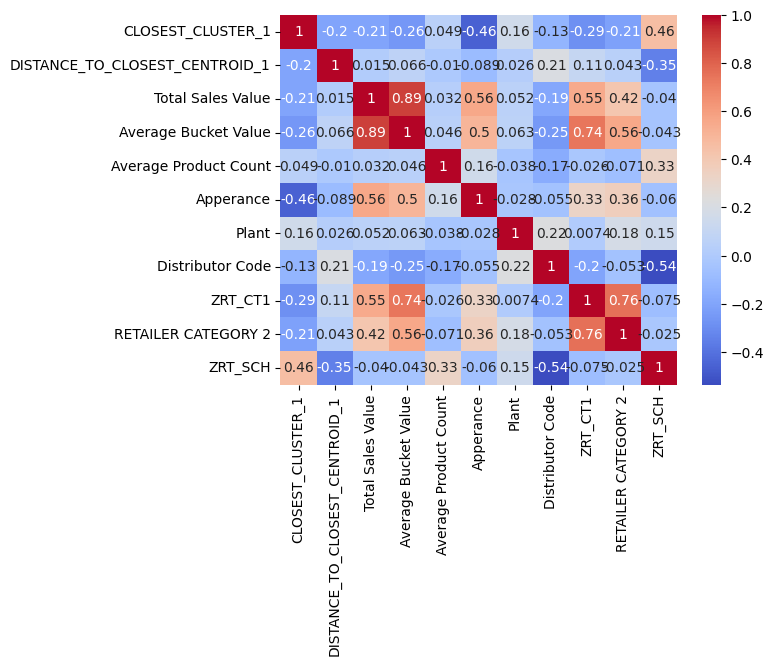

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

final_df[['Retailer Name', 'Apperance', 'Distributor Code', 'CP Group1']] = final_df[['Retailer Name', 'Apperance', 'Distributor Code', 'CP Group1']].astype(str)
corr_matrix = final_df.drop(['Retailer Name', 'CP Group1'], axis = 1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [214]:
final_df.dtypes

Retailer Name                      object
CLOSEST_CLUSTER_1                   int64
DISTANCE_TO_CLOSEST_CENTROID_1    float64
Total Sales Value                 float64
Average Bucket Value              float64
Average Product Count             float64
Apperance                          object
Plant                               int64
Distributor Code                   object
CP Group1                          object
ZRT_CT1                             int64
RETAILER CATEGORY 2                 int64
ZRT_SCH                             int64
dtype: object

In [215]:
final_df['Total Sales Value'] = final_df['Total Sales Value'].astype(float)
final_df['Average Bucket Value'] = final_df['Average Bucket Value'].astype(float)
final_df['CLOSEST_CLUSTER_1'] = final_df['CLOSEST_CLUSTER_1'].astype(str)

In [216]:
import plotly.express as px

px.scatter(final_df, x = 'Average Bucket Value', y = 'Total Sales Value', color = 'CLOSEST_CLUSTER_1',
           height = 700, width = 1200, hover_data = 'Retailer Name', )

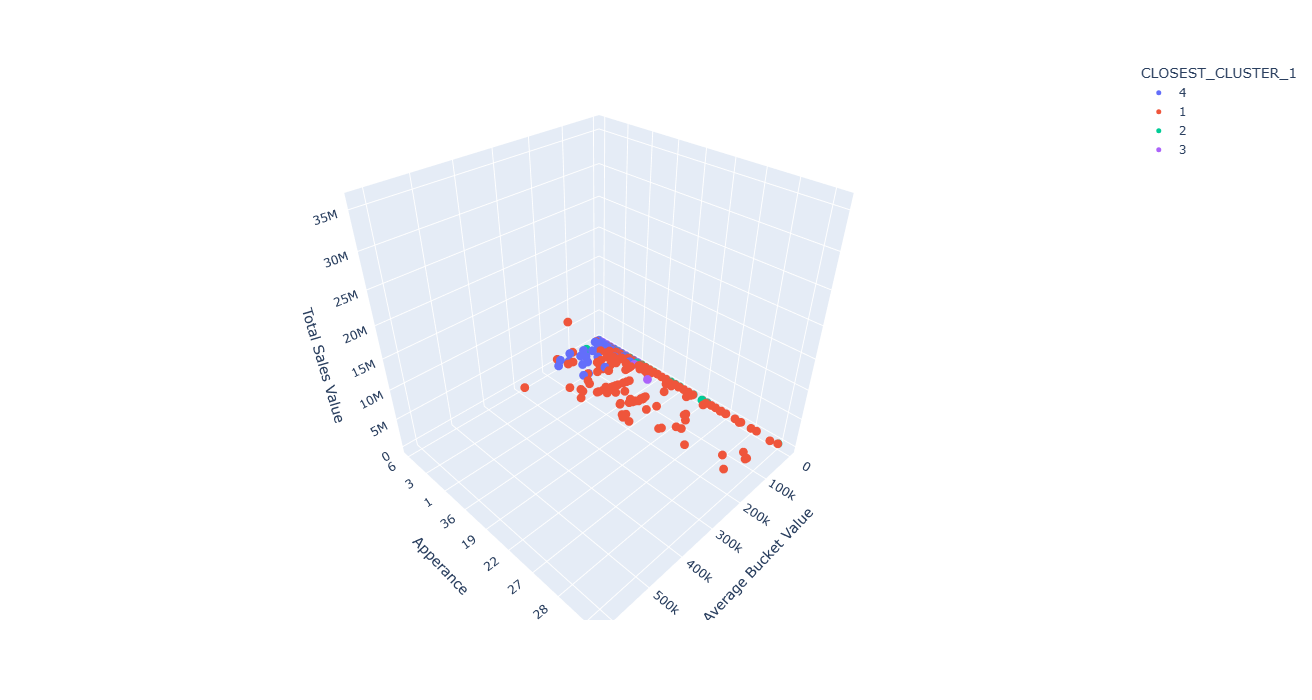

In [186]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(final_df, x='Average Bucket Value', y='Apperance', z='Total Sales Value',
              color = 'CLOSEST_CLUSTER_1',height = 700, width = 1200, hover_data = 'Retailer Name')
fig.update_traces(marker_size=5, selector=dict(type='scatter3d'))
fig.show()

In [152]:
save_df

,Retailer Name,CLOSEST_CLUSTER_1,DISTANCE_TO_CLOSEST_CENTROID_1,Total Sales Value,Average Bucket Value,Average Product Count,Apperance,Plant,Distributor Code,CP Group1,ZRT_CT1,RETAILER CATEGORY 2,ZRT_SCH
0,A P KM,4,0.379448,30027.80,5004.633333,10.666667,6,DP10,1056,None,Retail,Grocery,Rural Marketing
1,AADINATH COSMETIC,1,0.820639,3493361.48,205491.851765,3.294118,17,DP10,1073,None,Wholesale,WS,General Trade
2,AADITYA KIRANA,2,0.469642,28685.60,2048.971429,6.428571,14,DP17,10143,None,Retail,Grocery,General Trade
3,AAINATH PROVISION,2,0.421180,37356.64,2490.442667,8.000000,15,DP17,10143,None,Retail,Grocery,General Trade
4,AAKASH ENTERPRISE,1,0.808117,996000.04,99600.004000,3.400000,10,DP10,1073,None,Wholesale Loyalty,Wholesale Loyalty,General Trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,Y~RAMULU KIRANAM,4,0.765742,23165.76,7721.920000,6.666667,3,DP10,1030,None,Retail,Grocery,General Trade
1564,Y~SAMPATH KIRANAM,3,0.545126,23923.32,3987.220000,5.666667,6,DP10,1030,None,Retail,Grocery,General Trade
1565,ZAHOOR PROV STORE,2,0.807152,21121.68,1920.152727,5.272727,11,DP02,10176,None,Retail,General Store,General Trade
1566,ZAKIR KIRANAM,3,0.546228,15967.24,3991.810000,5.500000,4,DP10,1030,None,Retail,Grocery,General Trade


In [153]:
create_dataframe_from_pandas(
        CONN,
        save_df,
        "RETAILER_CLUSTERED_TABLE1",
        "EMAMI_DS_POC#DBUSER",
        force=True,
        replace=True,
        drop_exist_tab=False
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


In [366]:
# DataFrame(CONN, 'select * from EMAMI_DS_POC#DBUSER.RETAILER_CLUSTERED_TABLE').collect().dtypes

Retailer Name                      object
CLOSEST_CLUSTER_1                   int64
DISTANCE_TO_CLOSEST_CENTROID_1    float64
Total Sales Value                 float64
Average Bucket Value              float64
Average Product Count             float64
Apperance                         float64
Plant                              object
Distributor Code                   object
CP Group1                          object
ZRT_CT1                            object
RETAILER CATEGORY 2                object
ZRT_SCH                            object
dtype: object

In [231]:
# model.export_apply_code('JSON')